In [1]:
%pylab inline
import scipy
import numpy as np
from numpy.fft import fft2, fftshift, ifftshift
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

print('Python version:\n{}\n'.format(sys.version))
print('Numpy version:\t\t{}'.format(np.__version__))
print('matplotlib version:\t{}'.format(matplotlib.__version__))
print('Scipy version:\t\t{}'.format(scipy.__version__))

Populating the interactive namespace from numpy and matplotlib
Python version:
3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]

Numpy version:		1.18.1
matplotlib version:	3.1.3
Scipy version:		1.4.1


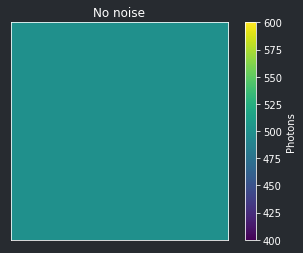

In [2]:
num_photons = 500
num_pixels  = 256
mu_p        = num_photons * np.ones((num_pixels, num_pixels))

fig, ax = plt.subplots()
img = ax.imshow(mu_p, vmin=400, vmax=600)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('No noise')

cb = plt.colorbar(img)
cb.set_label('Photons')

plt.show()

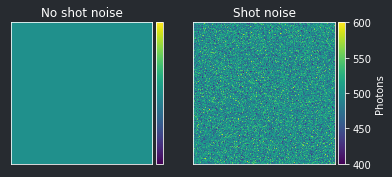

In [3]:


seed       = 42
rs         = np.random.RandomState(seed)
shot_noise = rs.poisson(num_photons, (num_pixels, num_pixels))

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('No shot noise')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Shot noise')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(img1, cax=cax)
cb1.set_label('Photons')

plt.show()

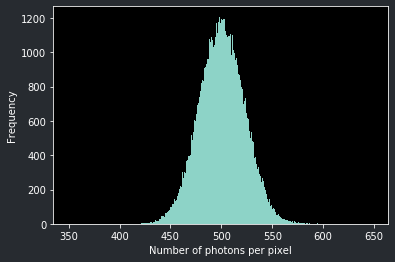

In [4]:
# It's also interesting to look at the distribution of photons hitting each pixel.
plt.hist(shot_noise.ravel(), bins=np.arange(350, 650))
plt.xlabel('Number of photons per pixel')
plt.ylabel('Frequency')
plt.show()

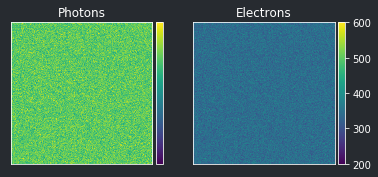

In [5]:
quantum_efficiency = 0.69
# Round the result to ensure that we have a discrete number of electrons
electrons = np.round(quantum_efficiency * shot_noise)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(shot_noise, vmin=200, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Photons')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons, vmin=200, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)

plt.show()

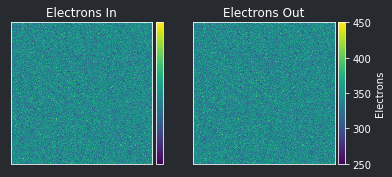

In [6]:
dark_noise = 2.29 # electrons
electrons_out = np.round(rs.normal(scale=dark_noise, size=electrons.shape) + electrons)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(electrons, vmin=250, vmax=450)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Electrons In')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons_out, vmin=250, vmax=450)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons Out')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)
cb.set_label('Electrons')

plt.show()

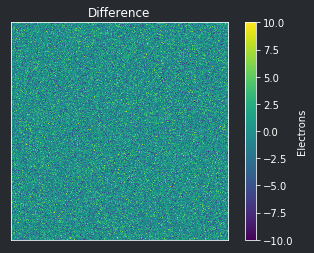

In [7]:
# Plot the difference between the two
fig, ax = plt.subplots()
img = ax.imshow(electrons - electrons_out, vmin=-10, vmax=10)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Difference')

cb = plt.colorbar(img)
cb.set_label('Electrons')

plt.show()

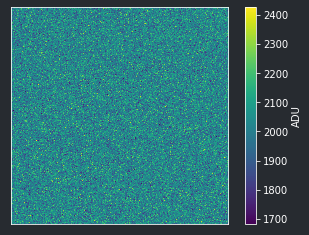

In [8]:
sensitivity = 5.88 # ADU/e-
bitdepth    = 12
max_adu     = np.int(2**bitdepth - 1)
adu         = (electrons_out * sensitivity).astype(np.int)
adu[adu > max_adu] = max_adu # models pixel saturation

fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()

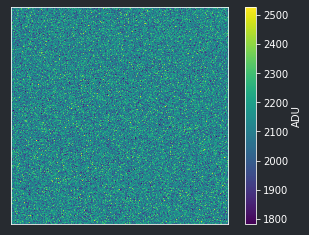

In [9]:
baseline  = 100 # ADU
adu      += baseline

# EDIT: Note that we could have easily just performed this next step once
# here, rather than in the previous step
adu[adu > max_adu] = max_adu


fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()


In [15]:
# Ground truth: a circular phase-only object
numPixels = 512
gtRadius  = 50 # ground truth radius, pixels
gtPhase   = 0.75 # radians
gtCenter  = numPixels / 2 # assumes numPixels is even
W, H      = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
gtMask    = np.sqrt((W - gtCenter)**2 + (H - gtCenter)**2) <= gtRadius # boundaries of the object
gt = np.ones((numPixels, numPixels), dtype=np.complex)
gt[gtMask] = np.exp(1j * gtPhase)

# Physical dimensions and sampling
pixelSize = 0.1 # microns
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

# Fourier transform of ground truth
GT = ifftshift(fft2(fftshift(gt))) * dx**2

# Angular spectrum propagator and spatial frequencies
def H(fx, fy, z, wavelength=0.5):
    print("fx:", fx)
    print("1 - (wavelength**2 * fx**2): ", 1 - (wavelength**2 * fx**2))
    square_root = np.sqrt(1 - (wavelength**2 * fx**2) - (wavelength**2 * fy**2))
    temp = exp(1j * 2 * np.pi * z / wavelength * square_root)
    temp[np.isnan(temp)] = 0 # replace nan's with zeros
    return temp

FX, FY = np.meshgrid(fx, fx)

print(shape(FX), shape(FY))

# Field at a distance of z=0
gt_prime = fftshift(ifft2(ifftshift(GT))) / dx**2

# Normalizing constant: makes the maximum photon count at z = 0 equal to 100 photons
norm = np.max(np.abs(gt_prime)**2) / 100
println(norm)

(512, 512) (512, 512)


NameError: name 'println' is not defined

In [11]:
# Function to add camera noise
def add_camera_noise(input_irrad_photons, qe=0.69, sensitivity=5.88,
                     dark_noise=2.29, bitdepth=12, baseline=100,
                     rs=np.random.RandomState(seed=42)):
 
    # Add shot noise
    photons = rs.poisson(input_irrad_photons, size=input_irrad_photons.shape)
    
    # Convert to electrons
    electrons = qe * photons
    
    # Add dark noise
    electrons_out = rs.normal(scale=dark_noise, size=electrons.shape) + electrons
    
    # Convert to ADU and add baseline
    max_adu     = np.int(2**bitdepth - 1)
    adu         = (electrons_out * sensitivity).astype(np.int) # Convert to discrete numbers
    adu += baseline
    adu[adu > max_adu] = max_adu # models pixel saturation
    
    return adu

C:\Users\saman\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  app.launch_new_instance()
C:\Users\saman\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


fx: [[-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 ...
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]]
1 - (wavelength**2 * fx**2):  [[-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 ...
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.7569078

fx: [[-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 ...
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]]
1 - (wavelength**2 * fx**2):  [[-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 ...
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.7569078

fx: [[-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 ...
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]
 [-4.99023438 -4.97074127 -4.95124817 ...  4.93175507  4.95124817
   4.97074127]]
1 - (wavelength**2 * fx**2):  [[-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 ...
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.75690785
  -5.81021659]
 [-5.86373478 -5.81021659 -5.75690785 ... -5.70380859 -5.7569078

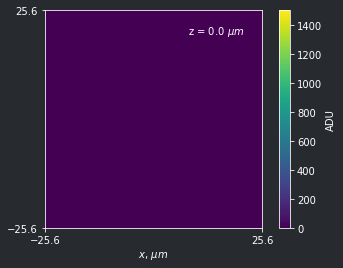

In [14]:
# Create the animation as before, this time add camera noise
numPoints = 100
z         = np.linspace(0, 100, num = numPoints)

fig, ax    = plt.subplots(nrows=1, ncols=1)
vmin, vmax = 0, 1500

img = ax.imshow(np.abs(gt_prime)**2 / norm, vmin=vmin, vmax=vmax)
img.set_extent([x[0], x[-1], x[0], x[-1]])
ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')

cb  = plt.colorbar(img)
cb.set_label('ADU')
cb.set_clim([vmin, vmax])

txt = ax.text(8, 20, 'z = {:.1f} $\mu m$'.format(0))

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((numPixels, numPixels)))
    return img,

# This function is called for each frame of the animation
def animate(frame):
    gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, z[frame], wavelength=0.525)))) / dx**2
    
    # Divide by norm to convert to a photons
    hologram = np.abs(gt_prime)**2 / norm
    
    # NEW: Add camera noise
    adu = add_camera_noise(hologram)
    
    #img.set_data(adu)
    #img.set_extent([x[0], x[-1], x[0], x[-1]])

    #txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return adu #img,


# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=numPoints,
                               init_func=init, interval=20, blit=True)

for i in range(20,40):
    animate(i)
# Save the animation
#myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
#anim.save('propagating_hologram_with_noise.mp4', writer = myWriter)
#plt.close()